In [1]:
import pandas as pd

df = pd.read_csv('dataset/in_hf.csv')
print(df.head())
print(df['labels'].value_counts())

                                                text  labels     source  \
0  @USER.wood17 knp lo gak berani bersumpah dan b...       1  Instagram   
1  haha, somad somad. Muka dekil otak 0% , kok ya...       1  Instagram   
2  hahaha, kaum sableng 212 kl berita begini mrk ...       1  Instagram   
3  hahaha, makin stress aja  ni umat sableng, dlu...       1  Instagram   
4       HIDUP PSI = partai SAMPAH indonesia..... ...       1  Instagram   

        dataset  nb_annotators  
0  ID_instagram              3  
1  ID_instagram              3  
2  ID_instagram              3  
3  ID_instagram              3  
4  ID_instagram              3  
labels
0    8256
1    6050
Name: count, dtype: int64


In [2]:
# label_mapping = {
#     'Non_HS' : 0,
#     'HS': 1
# }

# df['Label'] = df['labels']
# print(df.head())

df.rename(columns={'text': 'text', 'labels': 'label'}, inplace=True)
df_final = df[['text', 'label']]

print(df_final.head())

                                                text  label
0  @USER.wood17 knp lo gak berani bersumpah dan b...      1
1  haha, somad somad. Muka dekil otak 0% , kok ya...      1
2  hahaha, kaum sableng 212 kl berita begini mrk ...      1
3  hahaha, makin stress aja  ni umat sableng, dlu...      1
4       HIDUP PSI = partai SAMPAH indonesia..... ...      1


In [3]:
import re
import nltk
from nltk.corpus import stopwords as _nltk_stopwords

nltk.download('stopwords', quiet=True)

stopwords = set(_nltk_stopwords.words('indonesian'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

df_final['text'] = df_final['text'].apply(clean_text)
df_final.to_csv('dataset/in_hf_cleaned.csv', index=False)
print(df_final.head())


                                                text  label
0  wood17 knp lo gak berani bersumpah bertaruh kr...      1
1  haha somad somad muka dekil otak 0 ya g malu n...      1
2    hahaha kaum sableng 212 kl berita mrk buta tuli      1
3  hahaha stress aja ni umat sableng dlu raja sal...      1
4                  hidup psi partai sampah indonesia      1


C:\Users\septina erawati\AppData\Local\Temp\ipykernel_2004\2278696936.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['text'] = df_final['text'].apply(clean_text)


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "indobenchmark/indobert-base-p1"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
from datasets import Dataset

new_dataset = Dataset.from_pandas(df_final)

In [6]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=256)

df_tokenized = new_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/14306 [00:00<?, ? examples/s]

In [7]:
# from sklearn.model_selection import train_test_split

# train_df, test_df = train_test_split(df_tokenized, test_size=0.2, random_state=42, stratify=df_tokenized['label'])

df_tokenized = df_tokenized.class_encode_column("label")

split = df_tokenized.train_test_split(test_size=0.2, stratify_by_column='label', seed=42)

tokenized_train = split['train']
tokenized_test = split['test']

print(f"Train size: {len(tokenized_train)}, Test size: {len(tokenized_test)}")

Stringifying the column:   0%|          | 0/14306 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/14306 [00:00<?, ? examples/s]

Train size: 11444, Test size: 2862


In [8]:
from transformers import TrainingArguments

output_dir = "./results"

training_args = TrainingArguments(
    output_dir=output_dir,
    optim="adamw_torch",
    learning_rate=2e-5,
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps=400,
    save_steps=400,
    load_best_model_at_end=True,
    fp16=True,
)

In [9]:
import torch

print(torch.cuda.is_available())

True


In [10]:
from transformers import Trainer, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    processing_class=tokenizer,
)

trainer.train()

Step,Training Loss,Validation Loss
400,0.468200,0.411346
800,0.352100,0.395789
1200,0.265000,0.372722
1600,0.196000,0.516594
2000,0.109800,0.481431
2400,0.003900,0.671098
2800,0.093500,0.718297


TrainOutput(global_step=2864, training_loss=0.23256397998616016, metrics={'train_runtime': 1028.1445, 'train_samples_per_second': 44.523, 'train_steps_per_second': 2.786, 'total_flos': 6022085835079680.0, 'train_loss': 0.23256397998616016, 'epoch': 4.0})

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1652
           1       0.81      0.86      0.84      1210

    accuracy                           0.86      2862
   macro avg       0.85      0.86      0.85      2862
weighted avg       0.86      0.86      0.86      2862

Accuracy: 0.8570929419986024


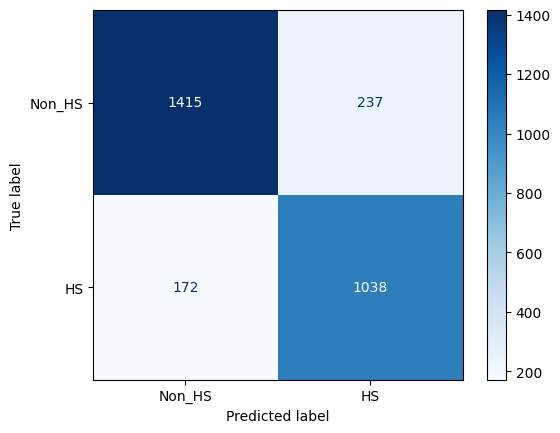

Precision, Recall, F1-Score: (np.float64(0.8588531147592107), np.float64(0.8570929419986024), np.float64(0.8575280239265793), None)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

predictions = trainer.predict(tokenized_test)
predicted_labels = np.argmax(predictions.predictions, axis=1)

true_labels = tokenized_test['label']

print(classification_report(true_labels, predicted_labels))

print("Accuracy:", accuracy_score(true_labels, predicted_labels))

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non_HS', 'HS'])
disp.plot(cmap='Blues')
plt.show()

print("Precision, Recall, F1-Score:", precision_recall_fscore_support(true_labels, predicted_labels, average='weighted'))

In [15]:
trainer.save_model("./final_model")

final_model = AutoModelForSequenceClassification.from_pretrained("./final_model")
final_tokenizer = AutoTokenizer.from_pretrained("./final_model")

from transformers import pipeline

predictor = pipeline("text-classification", model=final_model, tokenizer=final_tokenizer)

sentences_test_1 = "Saya harap indonesia bisa menjadi lebih baik untuk kedepannya."
sentences_test_2 = "Orang-orang dari suku tertentu adalah pembelah bangsa emang babi."
sentences_test_3 = "Mereka emang cuman orang kurang berpendidikan, omong doang bisanya, bodoh emang tuh orang."
sentences_test_4 = "Memang seperti itu suku jawa, selalu jadi pusat sorotan. Memang bangsat suku itu"
sentences_test_5 = "boro boro ingin maju, ijazah jelek luar biasa udah sok"
sentences_test_6 = "Siapa lagi kalau bukan yang dia yang melakukan, hutang tinggi karena siapa kalau bukan dia yang diagungkan" #sindiran

print(f'sentence1: {predictor(sentences_test_1)}')
print(f'sentence2: {predictor(sentences_test_2)}')
print(f'sentence3: {predictor(sentences_test_3)}')
print(f'sentence4: {predictor(sentences_test_4)}')
print(f'sentence5: {predictor(sentences_test_5)}')
print(f'sentence6: {predictor(sentences_test_6)}')

Device set to use cuda:0


sentence1: [{'label': 'LABEL_0', 'score': 0.9913111925125122}]
sentence2: [{'label': 'LABEL_1', 'score': 0.75503009557724}]
sentence3: [{'label': 'LABEL_1', 'score': 0.731673002243042}]
sentence4: [{'label': 'LABEL_0', 'score': 0.93001389503479}]
sentence5: [{'label': 'LABEL_1', 'score': 0.9757897853851318}]
sentence6: [{'label': 'LABEL_0', 'score': 0.8975595831871033}]


Sindiran tidak terbaca dengan benar (baru mendeteksi ketika kata kata frontal dilontarkan) kemungkinan karena tidak ada data yang memang berbau menyindir.

Sindiran sepertinya memiliki cara pengembangan model sendiri yang mungkin berbeda dengan deteksi hate speech (Spekulasi)

Terkadang bila terdapat pujian tetapi diakhiri dengan umpatan tidak dianggap sebagai Hate Speech (Spekulasi saya bisa saja ini tidak benar)